In [1]:
from pyspark.sql.functions import *       # added for the function 
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from operator import add


from datetime import datetime

spark = SparkSession.builder \
    .master('local') \
    .appName('WeeklyDelays') \
    .getOrCreate()

# Functions to add a 0 to days/months to make dates sortable
def formatDecimal(n):
    if len(n) == 1:
        return '0' + n
    else: 
        return n
    
def formatDate(n):
    n = n.split('-')
    return n[0]+'-'+formatDecimal(n[1])
    
def getWeek(y,m,d):
    return datetime(y,m,d).isocalendar()[1]

allflights = spark.read.load("./data/alldata.csv",format="csv", sep=",", header="true")

df = allflights.select("Year", "Month", "DayofMonth", "Origin", "DepDelay", "Dest", "ArrDelay", )
df = df.withColumn("Year", df["Year"].cast(IntegerType()))
df = df.withColumn("Month", df["Month"].cast(IntegerType()))
df = df.withColumn("DayofMonth", df["DayofMonth"].cast(IntegerType()))
df = df.where(col("Year").isNotNull() & col("Month").isNotNull() & col("DayofMonth").isNotNull() & col("Origin").isNotNull() & col("DepDelay").isNotNull() & col("Dest").isNotNull() & col("ArrDelay").isNotNull())

#df.show()

In [2]:
OutgoingDelay = df.rdd.map(lambda r: (r[0],getWeek(r[0],r[1],r[2]), r[3], r[4])).toDF()
OutgoingDelay = OutgoingDelay.select(concat(col("_1"), lit("-"), col("_2")).alias("Date"), col("_3").alias("Airport"), col("_4").alias("OutgoingDelay"))
OutgoingDelay = OutgoingDelay.filter((OutgoingDelay['OutgoingDelay'] > 15))
OutgoingDelay = OutgoingDelay.rdd.map(lambda x: ((formatDate(x[0]), x[1]), 1)) \
                                    .reduceByKey(lambda x, y: x+y) \
                                    .sortByKey().toDF()
OutgoingDelay = OutgoingDelay.select(col("_1").alias("OutDate"), col("_2").alias("OutgoingPenalty"))
#OutgoingDelay.show()

In [3]:
IncomingDelay = df.rdd.map(lambda r: (r[0],getWeek(r[0],r[1],r[2]), r[5], r[6])).toDF()
IncomingDelay = IncomingDelay.select(concat(col("_1"), lit("-"), col("_2")).alias('date'), col("_3").alias("Airport"), col("_4").alias("IncomingDelay"))
IncomingDelay = IncomingDelay.filter((IncomingDelay['IncomingDelay'] > 15))
IncomingDelay = IncomingDelay.rdd.map(lambda x: ((formatDate(x[0]), x[1]), 0.5)) \
                                    .reduceByKey(lambda x, y: x+y) \
                                    .sortByKey().toDF()
IncomingDelay = IncomingDelay.select(col("_1").alias("InDate"), col("_2").alias("IncomingPenalty"))
#IncomingDelay.show()

In [4]:
## Join the three tables to have each row contain the total and total canceled flights
PreDelays = OutgoingDelay.join(IncomingDelay, OutgoingDelay.OutDate == IncomingDelay.InDate, how='left').drop("InDate").na.fill(0)
#PreDelays.show()

In [5]:
Delays = PreDelays.rdd.map(lambda d: (d[0], d[1]+d[2])).toDF()
Delays = Delays.select('_1.*',col("_2").alias("Penalty"))
Delays = Delays.select(col("_1").alias("Date"), col("_2").alias("Airport"), col("Penalty"))
#Delays.show()

In [6]:
#Sort on airport code then on date
DelaysPerAirport = Delays.rdd.map(lambda x: ((x[1], x[0]), x[2])) \
                                    .sortBy(lambda x: -x[1]).toDF()
DelaysPerAirport = DelaysPerAirport.select(col("_1").alias("Airport-Date"), col("_2").alias("Penalty"))
DelaysPerAirport.show()

#Sort on date then on aiport code
DelaysPerDate = Delays.rdd.map(lambda x: ((x[0], x[1]), x[2])) \
                                    .sortBy(lambda x: -x[1]).toDF()
DelaysPerDate = DelaysPerDate.select(col("_1").alias("Date-Airport"), col("_2").alias("Penalty"))
DelaysPerDate.show()

+--------------+-------+
|  Airport-Date|Penalty|
+--------------+-------+
|[ATL, 2005-28]| 5618.5|
|[ATL, 2007-26]| 5581.5|
|[ORD, 2003-51]| 5336.0|
|[ORD, 2007-07]| 5258.0|
|[ATL, 2004-26]| 5171.0|
|[ATL, 2005-32]| 5135.5|
|[ATL, 2007-29]| 5110.5|
|[ATL, 2008-14]| 5070.0|
|[ATL, 2007-28]| 4922.0|
|[ATL, 2005-30]| 4821.5|
|[ORD, 2007-51]| 4784.0|
|[ATL, 2004-48]| 4767.0|
|[ATL, 2004-52]| 4752.5|
|[ATL, 2008-28]| 4738.5|
|[ATL, 2008-10]| 4734.0|
|[ATL, 2005-13]| 4704.5|
|[ATL, 2007-24]| 4698.5|
|[ORD, 2007-09]| 4697.0|
|[ORD, 2003-47]| 4666.5|
|[ATL, 2008-52]| 4642.5|
+--------------+-------+
only showing top 20 rows

+--------------+-------+
|  Date-Airport|Penalty|
+--------------+-------+
|[2005-28, ATL]| 5618.5|
|[2007-26, ATL]| 5581.5|
|[2003-51, ORD]| 5336.0|
|[2007-07, ORD]| 5258.0|
|[2004-26, ATL]| 5171.0|
|[2005-32, ATL]| 5135.5|
|[2007-29, ATL]| 5110.5|
|[2008-14, ATL]| 5070.0|
|[2007-28, ATL]| 4922.0|
|[2005-30, ATL]| 4821.5|
|[2007-51, ORD]| 4784.0|
|[2004-48, ATL]| 4767.0|

Text(0,0.5,'Penalty score')

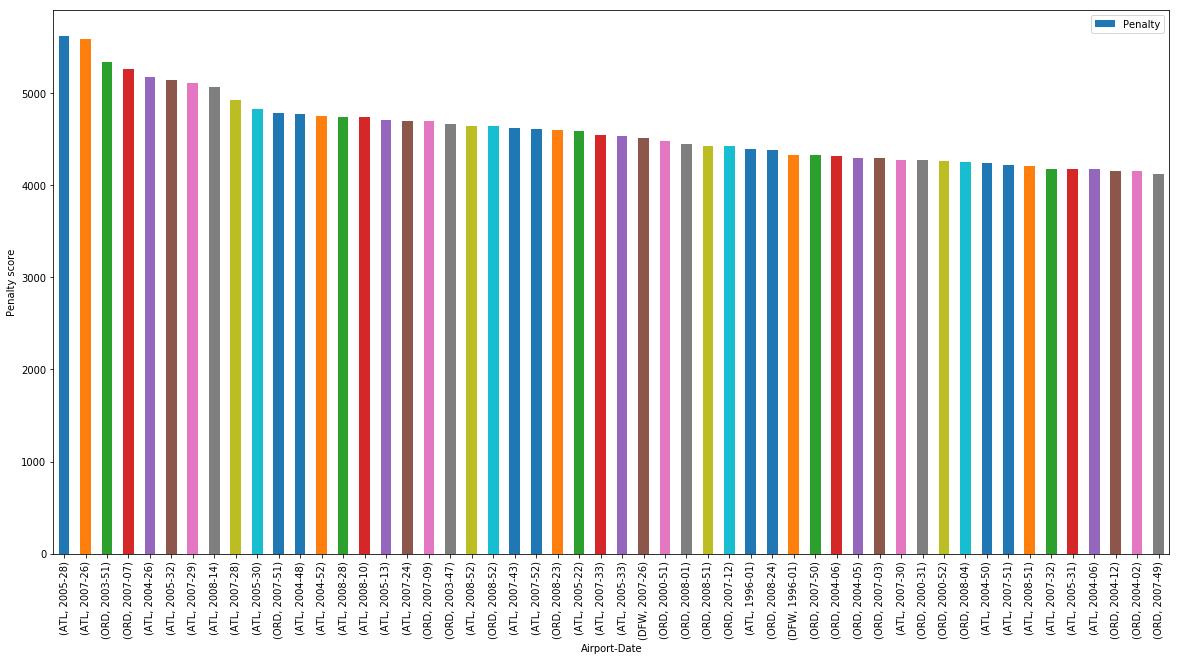

In [10]:
import matplotlib
import matplotlib.pyplot as plt

StatsPerAirport = DelaysPerAirport.toPandas()

ax = StatsPerAirport.head(52).plot.bar(x='Airport-Date', y='Penalty',figsize=(20, 10));
ax.set_ylabel("Penalty score")

In [9]:
## Statistics 
highest = StatsPerAirport.loc[StatsPerAirport['Penalty'].idxmax()] # Day with highest cancellations
#print(highest)
lowest = StatsPerAirport.loc[StatsPerAirport['Penalty'].idxmin()]  # Day with lowest cancellations
#print(lowest)
summary = DelaysPerAirport.describe('Penalty')
print('\nAirport and week with highest Penalty : %s on %s with %.f penalty' % (highest[0][0], highest[0][1], highest[1]))
print('Airport and week with lowest Penalty : %s on %s with %.f\n penalty' % (lowest[0][0], lowest[0][1], lowest[1]))
summary.show()


Airport and week with highest Penalty : ATL on 2005-28 with 5618 penalty
Airport and week with lowest Penalty : SPN on 1995-29 with 1
 penalty
+-------+------------------+
|summary|           Penalty|
+-------+------------------+
|  count|            157836|
|   mean|136.26528485263185|
| stddev|306.21019253976397|
|    min|               1.0|
|    max|            5618.5|
+-------+------------------+

